Pruebas de la API no oficial InstagramAPI

In [129]:
# Imports y login

from InstagramAPI.InstagramAPI import InstagramAPI
import numpy as np
import time
import getpass
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import operator
import pandas as pd

username = input("Usuario:")
pwd = getpass.getpass("Contraseña:")
#username = ""
#pwd = ""

myposts = []
has_more_posts = True
max_id = ""
likers = []
users = []
m_id = 0
l_dict = {}
n_users = 15 # Numero de usuarios que queremos para plots
user_notif = "nombre_usuario" # Para filtrar las notificaciones de un único usuario
show_not_following_back = False # Si lo pongo a true detalla las cuentas que sigo y no me siguen
show_fans = False # Si lo pongo a True detalla las cuentas que me siguen y yo no sigo      
posts_filename = username + "_posts_" + str(time.strftime("%y%m%d%H%M%S"))
fws_filename = username + "_followers_" + str(time.strftime("%y%m%d%H%M%S"))
show_notificaciones = False
show_notificaciones_follow = False
        
API = InstagramAPI(username, pwd)

API.login()
time.sleep(2)

Request return 429 error!
{'message': 'Please wait a few minutes before you try again.', 'status': 'fail'}
Request return 404 error!
Login success!



In [130]:
# Datos generales del perfil. Muestro el status y el nombre

API.getProfileData()
result = API.LastJson
my_id = API.LastJson['user']['pk']
# print (result)
print ("Estado:", result['status'])
print ("Conectado como:", result['user']['full_name'])

Estado: ok
Conectado como: Viajando al Cuadrado


In [131]:
# Datos del TimeLine. Puedo acceder a un montón de datos, revisar en código si interesa

API.timelineFeed()
result = API.LastJson
#print(result)

In [132]:
# Recorro mis posts, lo guardo todo en usuario_posts. De esta manera no tengo que acceder al servidor cada vez

while has_more_posts:
    API.getSelfUserFeed(maxid = max_id)
    if API.LastJson['more_available'] is not True:
        has_more_posts = False # Stop condition
        print ("Proceso terminado")
        
    max_id = API.LastJson.get('next_max_id', '')
    myposts.extend(API.LastJson['items']) # Merge lists
    time.sleep(2) # Slows the script down to avoid flooding the servers
    
print ("Número de posts:",len(myposts))
# pickle.dump(myposts,open(posts_filename,"wb")) # Guardo en un fichero para cuando sean muchos que no tarde en cargar. Falta cargarlo más adelante

Proceso terminado
Número de posts: 3


In [133]:
# Otro método mucho más corto para obtener el numero de posts...

API.getUsernameInfo(my_id)
n_media = API.LastJson['user']['media_count']
#print(n_media)

In [134]:
# Recoge los media likers

if((n_media*2/60.) >= 1):
    print ("Wait %.1f minutes" % (n_media*2/60.))
else:
    print ("Wait %.d seconds" % (n_media*2))

for i in range(len(myposts)):
    m_id = myposts[i]['id']
    API.getMediaLikers(m_id)
    likers += [API.LastJson]
    time.sleep(2)
    
print ("Done!")

Wait 6 seconds
Done!


In [135]:
# Saca los likes totales y los likes por usuarios únicos, y lo guarda en un diccionario

for i in likers:
        users += map(lambda x: i['users'][x]['username'],
                     range(len(i['users'])))
users_set = set(users)

for user in users_set:
    # l_dict structure - {username:number_of_liked_posts}
    l_dict[user] = users.count(user)

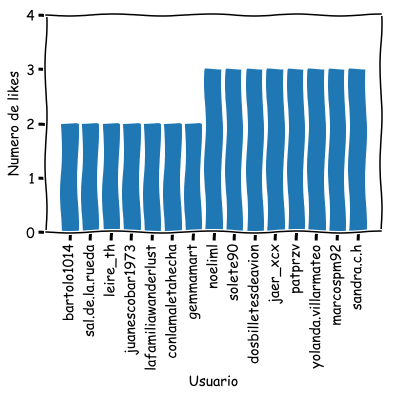

In [136]:
# Plot barras top usuarios que dan like a más posts

# Lista ordenada de tuplas con estructura [(usuario, likes), ...]
all_pairs = sorted(l_dict.items(), key=operator.itemgetter(1))

# Ajusto la escala vertical del plot a minimo-1 - maximo+1
min_posts = all_pairs[0][1] - 1
max_posts = all_pairs[-1][1] + 1

pairs = all_pairs[-n_users:]

y = list(map(lambda y: pairs[y][1], range(len(pairs))))
x = list(map(lambda y: pairs[y][0], range(len(pairs))))
fig = plt.figure()
plt.xkcd()
plt.xticks(range(len(pairs)), x, rotation='vertical')
plt.ylim([min_posts, max_posts])
plt.bar(range(len(pairs)), y)
plt.xlabel('Usuario')
plt.ylabel('Numero de likes')
plt.yticks(range(min_posts, max_posts+1))
plt.show()

<Figure size 432x288 with 0 Axes>

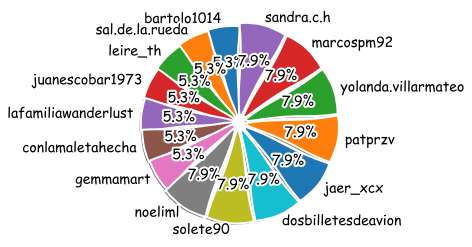

In [137]:
# Plot pie chart usuarios que dan like a más posts

plt.gcf().clear()

explode = list(map(lambda i: i/max(y)/10., y))
fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, 
        labels=x, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

In [138]:
# Estadisticas que se me ocurren

# Numero total de likes en publicaciones
print ("Likes totales:", len(users)) 

# Numero total de usuarios únicos que han dado like
print ("Usuarios únicos que han dado like:", len(users_set))

# Media de likes por usuario [likes totales / usuarios que han dado like alguna vez]
print ("Media de likes por usuario: %.2f" % (len(users) / len(users_set)))

# Numero de followings, gente a la que sigo
API.getUserFollowings(my_id)
print ("Número de followings: %d" % len(API.LastJson['users']))
following_list = API.LastJson['users']
user_list = map(lambda x: x['username'] , following_list)
following_set = set(user_list)

# Numero de followers, gente que me sigue
API.getUserFollowers(my_id)
print ("Número de followers: %d" % len(API.LastJson['users']))
followers_list = API.LastJson['users']
user_list = map(lambda x: x['username'] , followers_list)
followers_set = set(user_list)
pickle.dump(sorted(followers_set),open(fws_filename,"wb")) # Guardo en un fichero para poder comparar más adelante


# Numero de personas a las que sigo pero no me siguen, y sus cuentas
not_following_back = following_set - followers_set
print ("Número de gente a la que sigo y no me sigue:", len(not_following_back))
if (show_not_following_back == True):
    for i in range(len(not_following_back)):
        print ("    -", sorted((not_following_back))[i])

# Numero de personas que me siguen pero no sigo, y sus cuentas
fans = followers_set - following_set
print ("Número de gente que me sigue y yo no sigo:", len(fans))
if (show_fans == True):
    for i in range(len(fans)):
        print ("    -", sorted((fans))[i])

Likes totales: 129
Usuarios únicos que han dado like: 100
Media de likes por usuario: 1.29
Número de followings: 193
Número de followers: 76
Número de gente a la que sigo y no me sigue: 120
Número de gente que me sigue y yo no sigo: 3


In [139]:
# Últimas notificaciones de actividad. Creo que no salen todas, ¿es posible sacarlas?
act_dates = []
follow_dates = []

API.getRecentActivity()
get_recent_activity_response = API.LastJson

print ("Número de notificaciones:",len(get_recent_activity_response['old_stories']))
for notification in get_recent_activity_response['old_stories']:
    act_dates.append (pd.to_datetime(time.ctime(notification['args']['timestamp'])))
    if (show_notificaciones == True):       
        print (pd.to_datetime(time.ctime(notification['args']['timestamp'])), ":", end = " ")
        print (notification['args']['text'])
        
for notification in get_recent_activity_response['old_stories']:
    if(notification['type']==3): # FOLLOW    
        follow_dates.append (pd.to_datetime(time.ctime(notification['args']['timestamp'])))
        if (show_notificaciones_follow == True):       
            print (pd.to_datetime(time.ctime(notification['args']['timestamp'])), ":", end = " ")
            print (notification['args']['text'])
        
print ("Número de follows:",len(follow_dates))


Número de notificaciones: 62
Número de follows: 33


In [140]:
# Notificaciones de un sólo usuario (el definido al principio)

for notification in get_recent_activity_response['old_stories']:
    text = notification['args']['text']
    if user_notif in text:
        print (text)

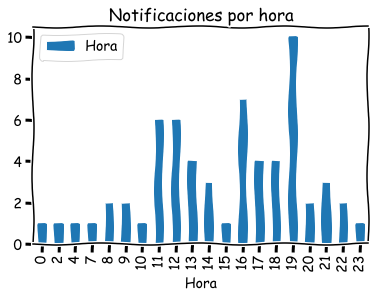

In [141]:
# Plot que muestra el número de notificaciones por hora (del listado total de últimas notificaciones)

df = pd.DataFrame({"Hora":act_dates})
df.groupby(df["Hora"].dt.hour).count().plot(kind="bar", title="Notificaciones por hora")

Número de usuarios con 1 likes: 79
Número de usuarios con 2 likes: 13
Número de usuarios con 3 likes: 8


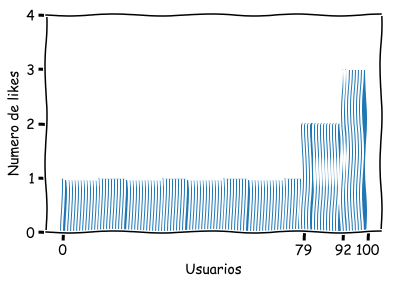

In [142]:
# Plot barras total likes a posts

# Lista ordenada de tuplas con estructura [(usuario, likes), ...]
all_pairs = sorted(l_dict.items(), key=operator.itemgetter(1))

# Ajusto la escala vertical del plot 0 - maximo+1
max_posts = all_pairs[-1][1] + 1

# Meto el numero de usuarios en listas
count = []
acc_count = [0]
for num in range(max_posts):
    count.append(0)
    for i in range(len(users_set)):
        if (all_pairs[i][1] == num):
            count[num] += 1
    if num > 0:
        numero = count[num]+acc_count[num-1]
        acc_count.append(count[num]+acc_count[num-1])
        print("Número de usuarios con %d likes: %d" % (num,  count[num]))

# Plot
y = list(map(lambda y: all_pairs[y][1], range(len(all_pairs))))
x = list(map(lambda y: all_pairs[y][0], range(len(all_pairs))))
fig = plt.figure()
plt.xkcd()
plt.xticks(acc_count)
plt.ylim([0, max_posts])
plt.bar(range(len(all_pairs)), y)
plt.xlabel('Usuarios')
plt.ylabel('Numero de likes')
plt.yticks(range(min_posts, max_posts+1))
plt.show()